# Bank churn prediction

In [120]:
# importing libraries
import os
import numpy as np
from scipy import stats
from scipy.stats import zscore
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import silhouette_score
import warnings
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.layers import Dense, Dropout
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc

## I. Exploratory data analysis

In [121]:
'''Reading the data and showcasing it'''
df = pd.read_csv('../Data/bank_nn.csv')
columns = df.columns
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [122]:
df.drop(columns = ['RowNumber','CustomerId', 'Surname'], inplace=True) # dropping columns unique to each customer

In [123]:
'''Dataframe information'''
df.head()
s1 = df.shape
print(df.shape) # Number of rows and columns in the dataframe
print('\033[1m'+ 'Null values: ' , df.isnull().values.any()) # To check for null values in the dataframe and print in bold
print('\033[0m') # To remove bold formatting
print(df.info()) # To check the data type of the columns of the dataframe
print(df.describe().T) # To review the statistical summary of the dataframe
df.head()

(10000, 11)
Null values:  False

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB
None
                   count           mean           std     min       25%  \
CreditScore      10000.0     650.528800     96.653299  350.00    584.00   
Age              10000.0      38.921800   

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [124]:
'''Converting object type columns (gender) into categorical type'''
rstruct={'Geography':{'France':0, 'Spain':1, 'Germany':2}}
df=df.replace(rstruct)
onehotcol = ['Gender', 'Geography']
df=pd.get_dummies(df, columns=onehotcol)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Female,Gender_Male,Geography_0,Geography_1,Geography_2
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,1,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,1,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,1,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0,0,1,0


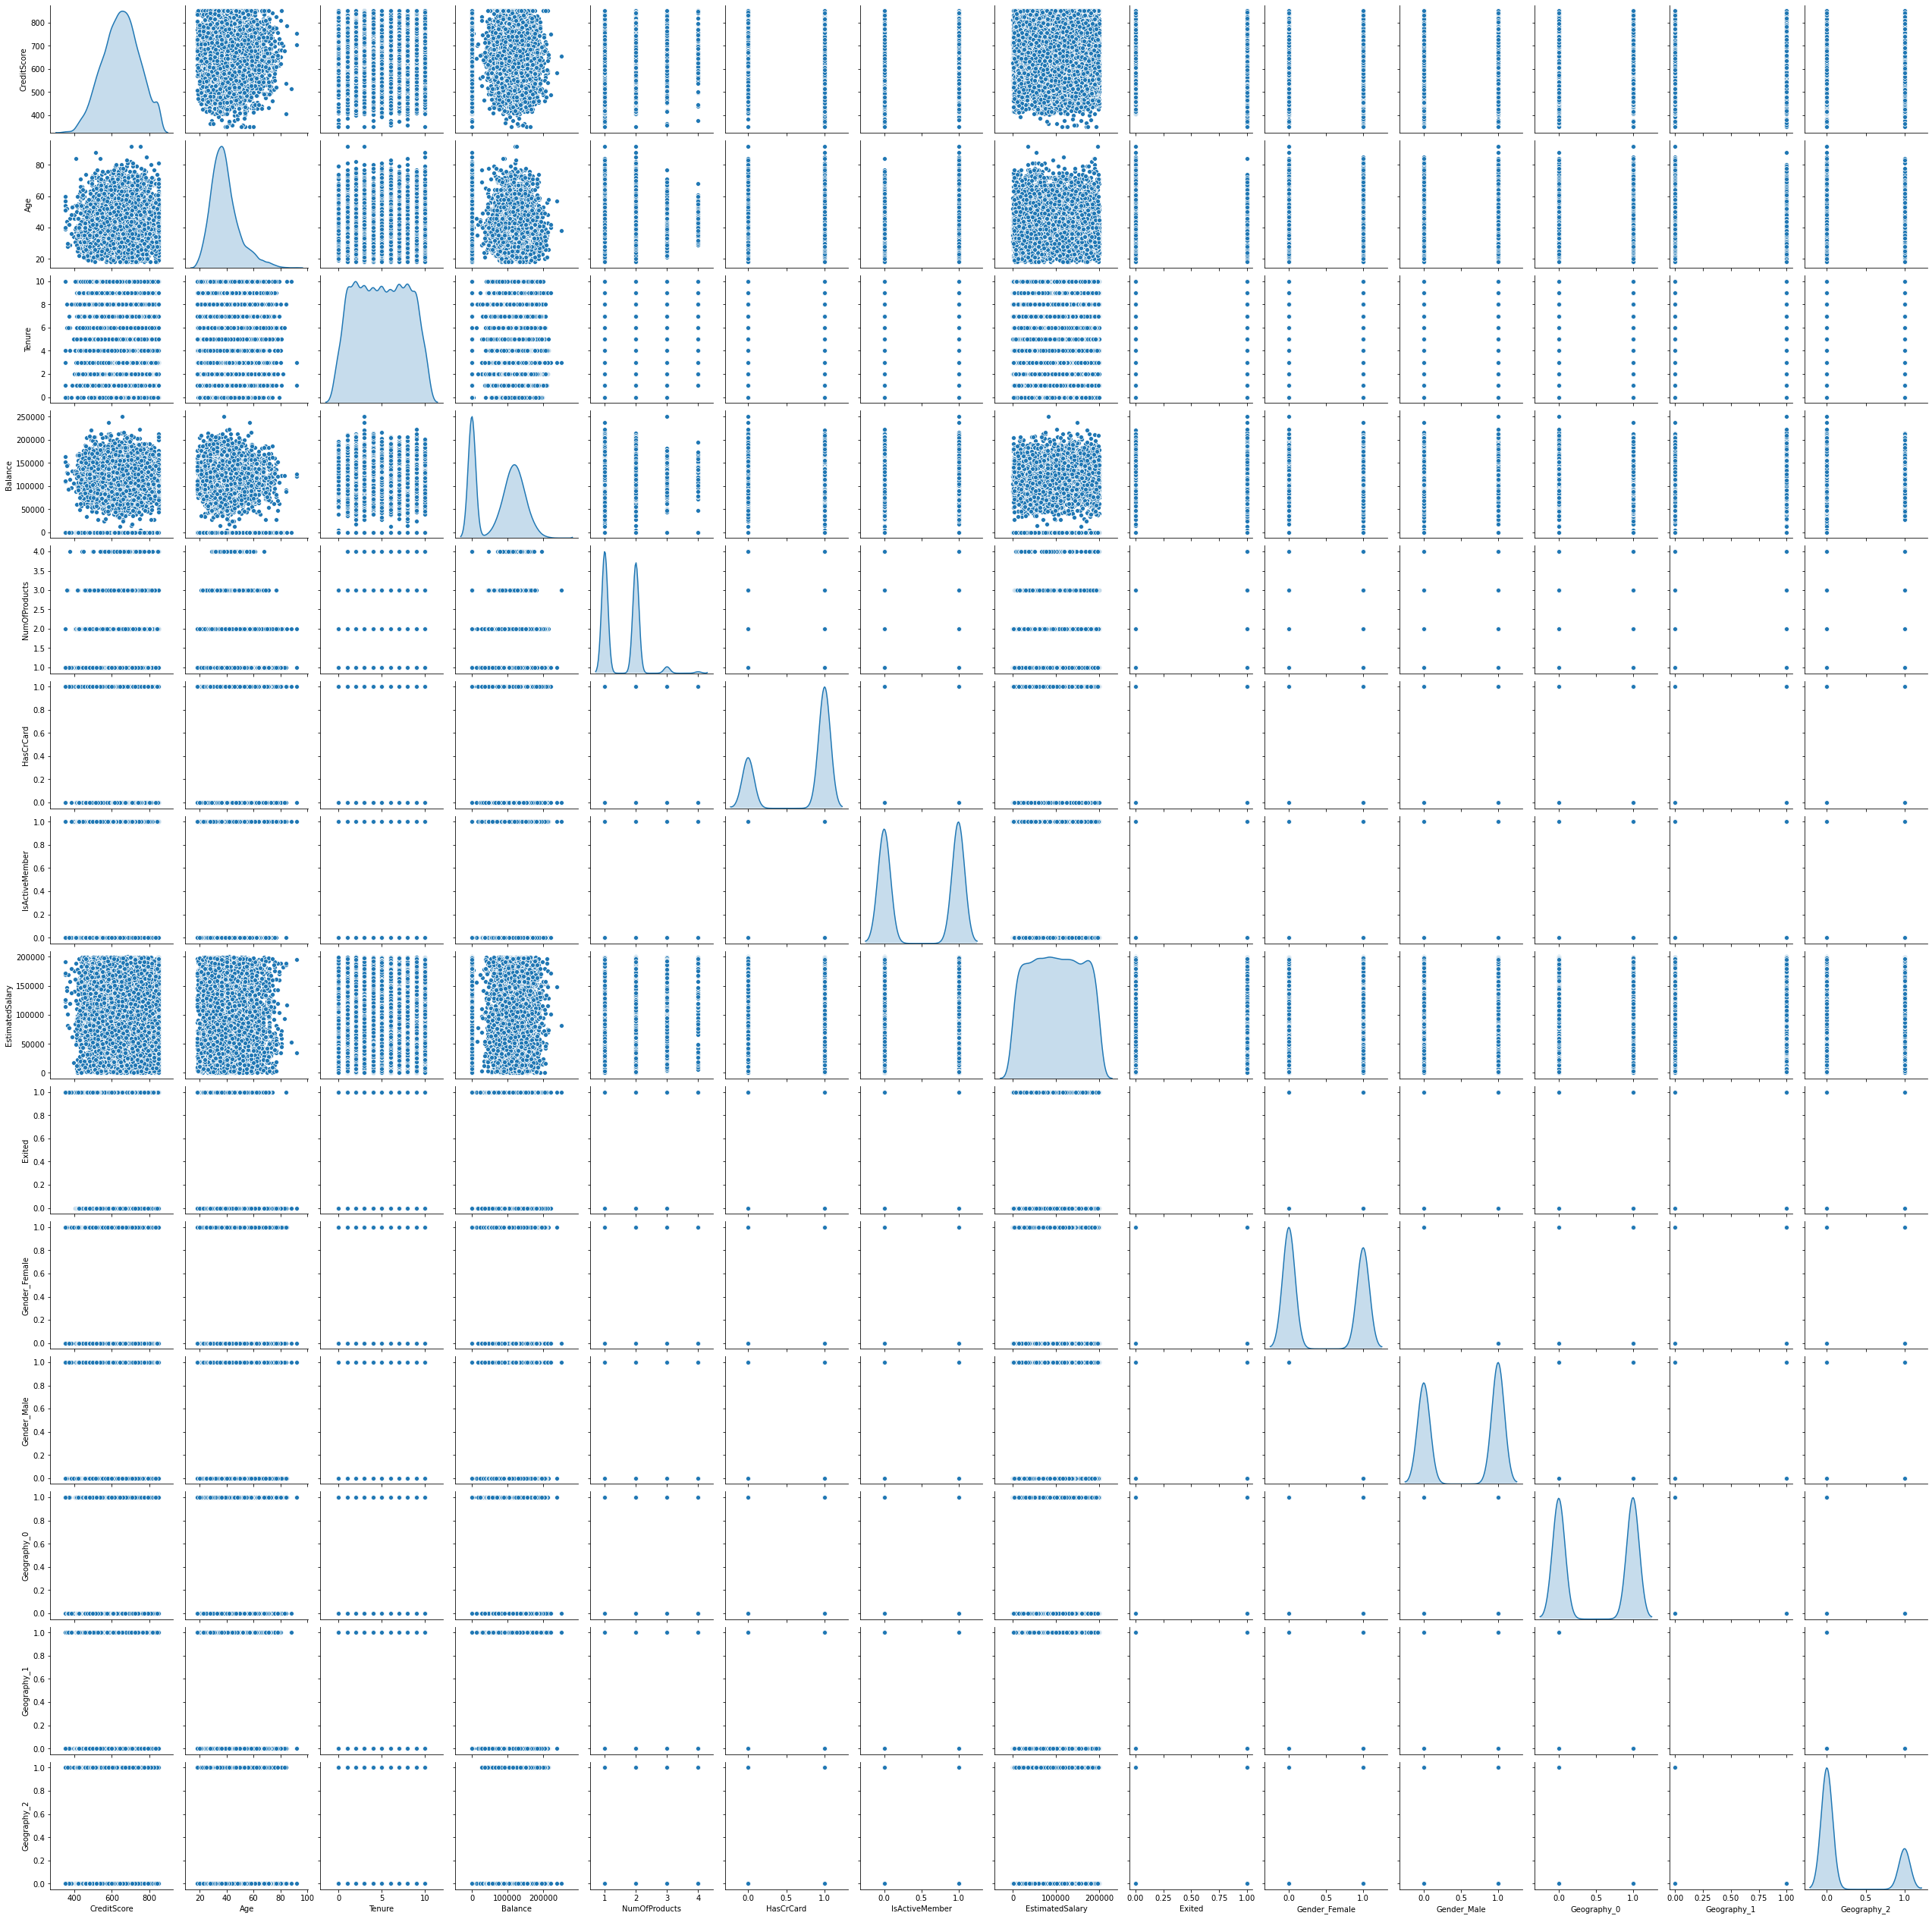

In [30]:
'''Bivariate analysis'''
sns.pairplot(df, diag_kind='kde')

                 CreditScore       Age    Tenure   Balance  NumOfProducts  \
CreditScore         1.000000 -0.003965  0.000842  0.006268       0.012238   
Age                -0.003965  1.000000 -0.009997  0.028308      -0.030680   
Tenure              0.000842 -0.009997  1.000000 -0.012254       0.013444   
Balance             0.006268  0.028308 -0.012254  1.000000      -0.304180   
NumOfProducts       0.012238 -0.030680  0.013444 -0.304180       1.000000   
HasCrCard          -0.005458 -0.011721  0.022583 -0.014858       0.003183   
IsActiveMember      0.025651  0.085472 -0.028362 -0.010084       0.009612   
EstimatedSalary    -0.001384 -0.007201  0.007784  0.012797       0.014204   
Exited             -0.027094  0.285323 -0.014001  0.118533      -0.047820   
Gender_Female       0.002857  0.027544 -0.014733 -0.012087       0.021859   
Gender_Male        -0.002857 -0.027544  0.014733  0.012087      -0.021859   
Geography_0        -0.008928 -0.039208 -0.002848 -0.231329       0.001230   

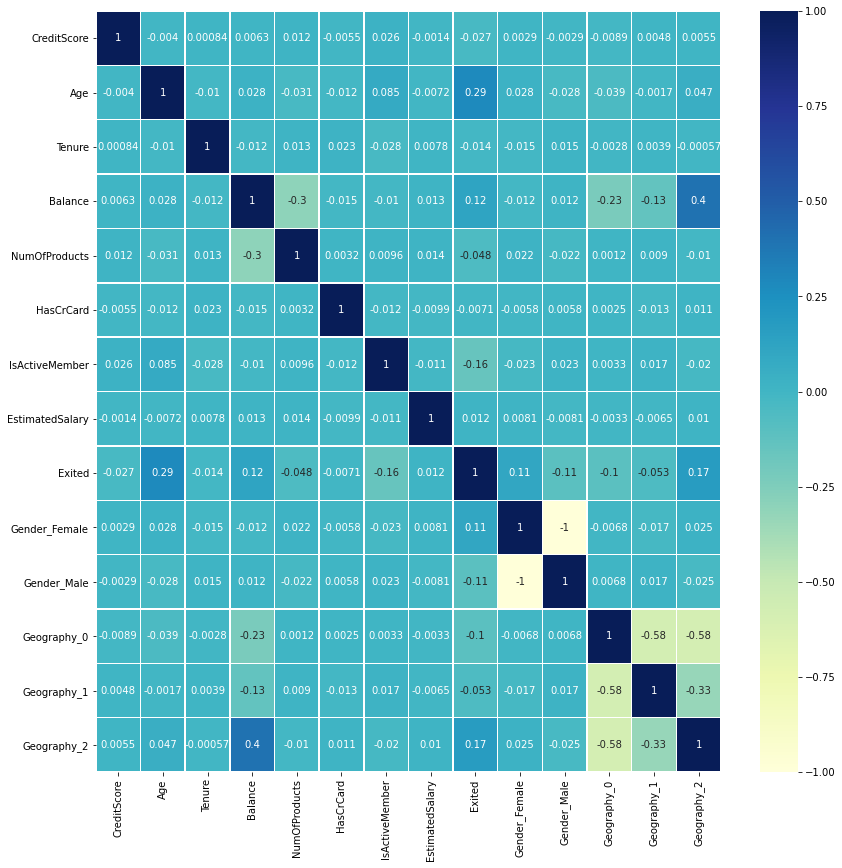

In [31]:
corr = df.corr() # Correlation matrix
print(corr)
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(corr, annot=True, linewidths=.5, center=0, cbar=True, cmap="YlGnBu")

## II. Training and testing data

In [125]:
'''Splitting the data into train and test sets'''
X = df.drop('Exited', axis=1)
Y = df.Exited
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.25, random_state = 20)
# Normalizing the data using scaling techniques
standardScaler = StandardScaler()
xtrain = standardScaler.fit_transform(xtrain)
xtest = standardScaler.fit_transform(xtest)
xtrain

array([[-0.60390003, -0.57054921,  1.37625225, ...,  1.00910814,
        -0.5818665 , -0.57981364],
       [ 0.04473598,  0.28882669,  0.68299603, ...,  1.00910814,
        -0.5818665 , -0.57981364],
       [ 0.30213122, -1.42992512,  0.33636792, ...,  1.00910814,
        -0.5818665 , -0.57981364],
       ...,
       [ 0.50804742,  1.43466124, -0.70351641, ..., -0.99097407,
        -0.5818665 ,  1.72469209],
       [-2.2615254 , -0.76152164, -0.01026019, ...,  1.00910814,
        -0.5818665 , -0.57981364],
       [-0.78922461,  1.05271639, -1.74340074, ..., -0.99097407,
         1.71860727, -0.57981364]])

In [126]:
'''creating a model'''
model = Sequential()
model.add(Dense(12, input_shape=(13,), activation='relu'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
sgd = optimizers.Adam(0.025)
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_152 (Dense)            (None, 12)                168       
_________________________________________________________________
dense_153 (Dense)            (None, 16)                208       
_________________________________________________________________
dense_154 (Dense)            (None, 2)                 34        
_________________________________________________________________
dense_155 (Dense)            (None, 1)                 3         
Total params: 413
Trainable params: 413
Non-trainable params: 0
_________________________________________________________________


In [127]:
'''training data'''
model.fit(xtrain, ytrain.values, batch_size=20, epochs=100, verbose=0)

In [128]:
loss, acc = model.evaluate(xtest, ytest, verbose=1)
print('Accuracy: %.3f'  % acc)
print('Loss: %.3f' % loss)

79/79 [==============================] - 0s 926us/step - loss: 0.3684 - accuracy: 0.8596
Accuracy: 0.860
Loss: 0.368


In [138]:
'''making a function to change hyperparameters and observe effect on metric'''
def optmodel(n1, n2, n3, lr):
    model = Sequential()
    model.add(Dense(n1, input_shape=(13,), activation='relu'))
    model.add(Dense(n2, activation='tanh'))
    model.add(Dense(n3, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    sgd = optimizers.Adam(lr)
    model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy'])
    model.fit(xtrain, ytrain.values, batch_size=20, epochs=100, verbose=0)
    loss, acc = model.evaluate(xtest, ytest, verbose=1)
    res = [loss, acc]
    return res

n1 = [10,50,100,300,500]
n2 = [15, 60, 120, 360, 600]
n3 = [2, 3, 4]
lr = [0.1, 0.01, 0.001, 0.0001, 0.00001]
r = []
for i in range(0,np.size(n1)):
    r.append(optmodel(n1[i], n2[1], n3[0], lr[2])[1])

79/79 [==============================] - 0s 898us/step - loss: 0.7096 - accuracy: 0.8196


79/79 [==============================] - 0s 878us/step - loss: 0.4519 - accuracy: 0.8176


Text(0, 0.5, 'Accuracy')

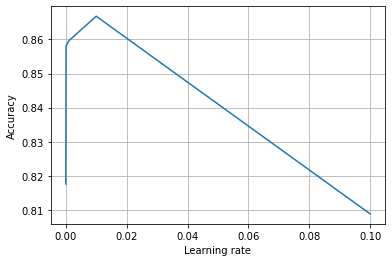

In [139]:
# effect of different learning rates
r3 = []
for i in range(np.size(lr)):
    r3.append(optmodel(n1[0], n2[1], n3[0], lr[i])[1])
plt.plot(lr, r3)
plt.grid()
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')

In [141]:
'''creating a model'''
model = Sequential()
model.add(Dense(10, input_shape=(13,), activation='relu'))
model.add(Dense(60, activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
sgd = optimizers.Adam(0.01)
model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy'])
model.summary()

'''training data'''
model.fit(xtrain, ytrain.values, batch_size=20, epochs=100, verbose=0)

loss, acc = model.evaluate(xtest, ytest, verbose=1)
print('Accuracy: %.3f'  % acc)
print('Loss: %.3f' % loss)

ypred = model.predict_classes(xtest)
print('Accuracy : '+ str(model.evaluate(xtest,ytest)[1]))
print('Recall_score: ' + str(recall_score(ytest,ypred)))
print('Precision_score: ' + str(precision_score(ytest, ypred)))
print('F-score: ' + str(f1_score(ytest,ypred)))
confusion_matrix(ytest, ypred)

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_280 (Dense)            (None, 10)                140       
_________________________________________________________________
dense_281 (Dense)            (None, 60)                660       
_________________________________________________________________
dense_282 (Dense)            (None, 2)                 122       
_________________________________________________________________
dense_283 (Dense)            (None, 1)                 3         
Total params: 925
Trainable params: 925
Non-trainable params: 0
_________________________________________________________________
79/79 [==============================] - 0s 3ms/step - loss: 0.3608 - accuracy: 0.8644
Accuracy: 0.864
Loss: 0.361
79/79 [==============================] - 0s 3ms/step - loss: 0.3608 - accuracy: 0.8644
Accuracy : 0.8644000291824341
Recall_score: 0.40794

array([[1966,   56],
       [ 283,  195]])